In [33]:
import sys

sys.path.append('../..') # Add backtester base dir to $PYTHONPATH

In [34]:
%config InlineBackend.figure_format="retina"
%matplotlib inline
import pyfolio as pf
import pandas as pd
import os
import matplotlib.pyplot as plt
import altair as alt

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (14, 8)

In [35]:
from backtester.datahandler import HistoricalOptionsData
from backtester.strategy import Strategy, StrategyLeg
from backtester.option import Type, Direction
from backtester import Backtest
from backtester.statistics import monthly_returns_heatmap, returns_histogram, returns_chart

In [36]:
# Cleaned up data
data = HistoricalOptionsData("options_data_clean_v2.h5", key="/SPX", where='quotedate >= "2006-12-06" & quotedate <= "2015-08-21"')
schema = data.schema

We now run a [long (ATM) straddle](https://www.investopedia.com/terms/l/longstraddle.asp) 45 DTE. This is the opposite of the previous strategy, where we enter buying the contracts instead of selling, and therefore profit from big movements in the underlying asset's price. 

In [37]:
# Long (ATM) straddle
long_straddle = Strategy(schema)

leg1 = StrategyLeg("leg_1", schema, option_type=Type.CALL, direction=Direction.BUY)
leg1.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg1.exit_filter = (schema.dte <= 2)

leg2 = StrategyLeg("leg_2", schema, option_type=Type.PUT, direction=Direction.BUY)
leg2.entry_filter = (schema.underlying == "SPX") & (schema.dte >= 40) & (schema.dte <= 50) & (schema.strike <= schema.underlying_last * 1.05) & (schema.strike >= schema.underlying_last * 0.95)
leg2.exit_filter = (schema.dte <= 2)

long_straddle.add_legs([leg1, leg2])
long_straddle.exit_thresholds = (0.25, 0.25)

In [38]:
bt = Backtest()
bt.strategy = long_straddle
bt.data = data
bt.stop_if_broke = False

In [39]:
bt.run(monthly=False)

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:04:40


leg_1                                              \
                contract underlying expiration  type  strike    cost   
0     SXY070120C01350000        SPX 2007-01-20  call  1350.0  7520.0   
1     SXY070120C01340000        SPX 2007-01-20  call  1340.0  7990.0   
2     SXY070120C01345000        SPX 2007-01-20  call  1345.0  7580.0   
3     SXY070120C01355000        SPX 2007-01-20  call  1355.0  7030.0   
4     SXY070217C01350000        SPX 2007-02-17  call  1350.0  8130.0   
...                  ...        ...        ...   ...     ...     ...   
1681  SPX150918C02005000        SPX 2015-09-18  call  2005.0 -8030.0   
1682  SPX150918C02000000        SPX 2015-09-18  call  2000.0 -5810.0   
1683  SPX150918C01995000        SPX 2015-09-18  call  1995.0 -6160.0   
1684  SPX150918C01990000        SPX 2015-09-18  call  1990.0 -6520.0   
1685  SPX150918C02010000        SPX 2015-09-18  call  2010.0 -5120.0   

                              leg_2                                     \
          order            contract underlying expiration type  strike   
0     Order.BTO  SXY070120P01350000        SPX 2007-01-20  put  1350.0   
1     Order.BTO  SXY070120P01340000        SPX 2007-01-20  put  1340.0   
2     Order.BTO  SXY070120P01345000        SPX 2007-01-20  put  1345.0   
3     Order.BTO  SXY070120P01355000        SPX 2007-01-20  put  1355.0   
4     Order.BTO  SXY070217P01350000        SPX 2007-02-17  put  1350.0   
...         ...                 ...        ...        ...  ...     ...   
1681  Order.STC  SPX150918P02005000        SPX 2015-09-18  put  2005.0   
1682  Order.STC  SPX150918P02000000        SPX 2015-09-18  put  2000.0   
1683  Order.STC  SPX150918P01995000        SPX 2015-09-18  put  1995.0   
1684  Order.STC  SPX150918P01990000        SPX 2015-09-18  put  1990.0   
1685  Order.STC  SPX150918P02010000        SPX 2015-09-18  put  2010.0   

                         totals                    
        cost      order    cost    qty       date  
0      470.0  Order.BTO  7990.0  125.0 2006-12-06  
1      570.0  Order.BTO  8560.0  116.0 2006-12-07  
2      550.0  Order.BTO  8130.0  123.0 2006-12-08  
3      510.0  Order.BTO  7540.0  132.0 2006-12-11  
4      580.0  Order.BTO  8710.0  114.0 2006-12-29  
...      ...        ...     ...    ...        ...  
1681 -1360.0  Order.STC -9390.0   79.0 2015-08-19  
1682 -2760.0  Order.STC -8570.0   79.0 2015-08-20  
1683 -2650.0  Order.STC -8810.0   82.0 2015-08-20  
1684 -2530.0  Order.STC -9050.0   81.0 2015-08-20  
1685 -3080.0  Order.STC -8200.0   89.0 2015-08-20  

[1686 rows x 17 columns]

In [40]:
bt.summary()

,Strategy
Total trades,842
Number of wins,298
Number of losses,544
Win %,35.39%
Largest loss,$998310.00
Profit factor,0.55
Average profit,$-98444.02
Average P&L %,-0.03%
Total P&L %,-8371.90%


/usr/local/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:445: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1
/usr/local/anaconda3/lib/python3.7/site-packages/empyrical/stats.py:1492: RuntimeWarning: invalid value encountered in log1p
  cum_log_returns = np.log1p(returns).cumsum()


Start date,2006-12-06
End date,2015-08-21
Total months,104
,Backtest
Annual return,nan%
Cumulative returns,-8313.2%
Annual volatility,1571.6%
Sharpe ratio,-0.01
Calmar ratio,NaN
Stability,NaN
Max drawdown,-2191.1%


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2191.08,2007-05-02,2015-08-20,NaT,NaN
1,130.67,2007-02-20,2007-03-13,2007-04-16,40
2,126.35,2006-12-15,2007-01-05,2007-01-12,21
3,96.30,2007-01-12,2007-01-29,2007-02-01,15
4,81.62,2007-02-07,2007-02-12,2007-02-14,6


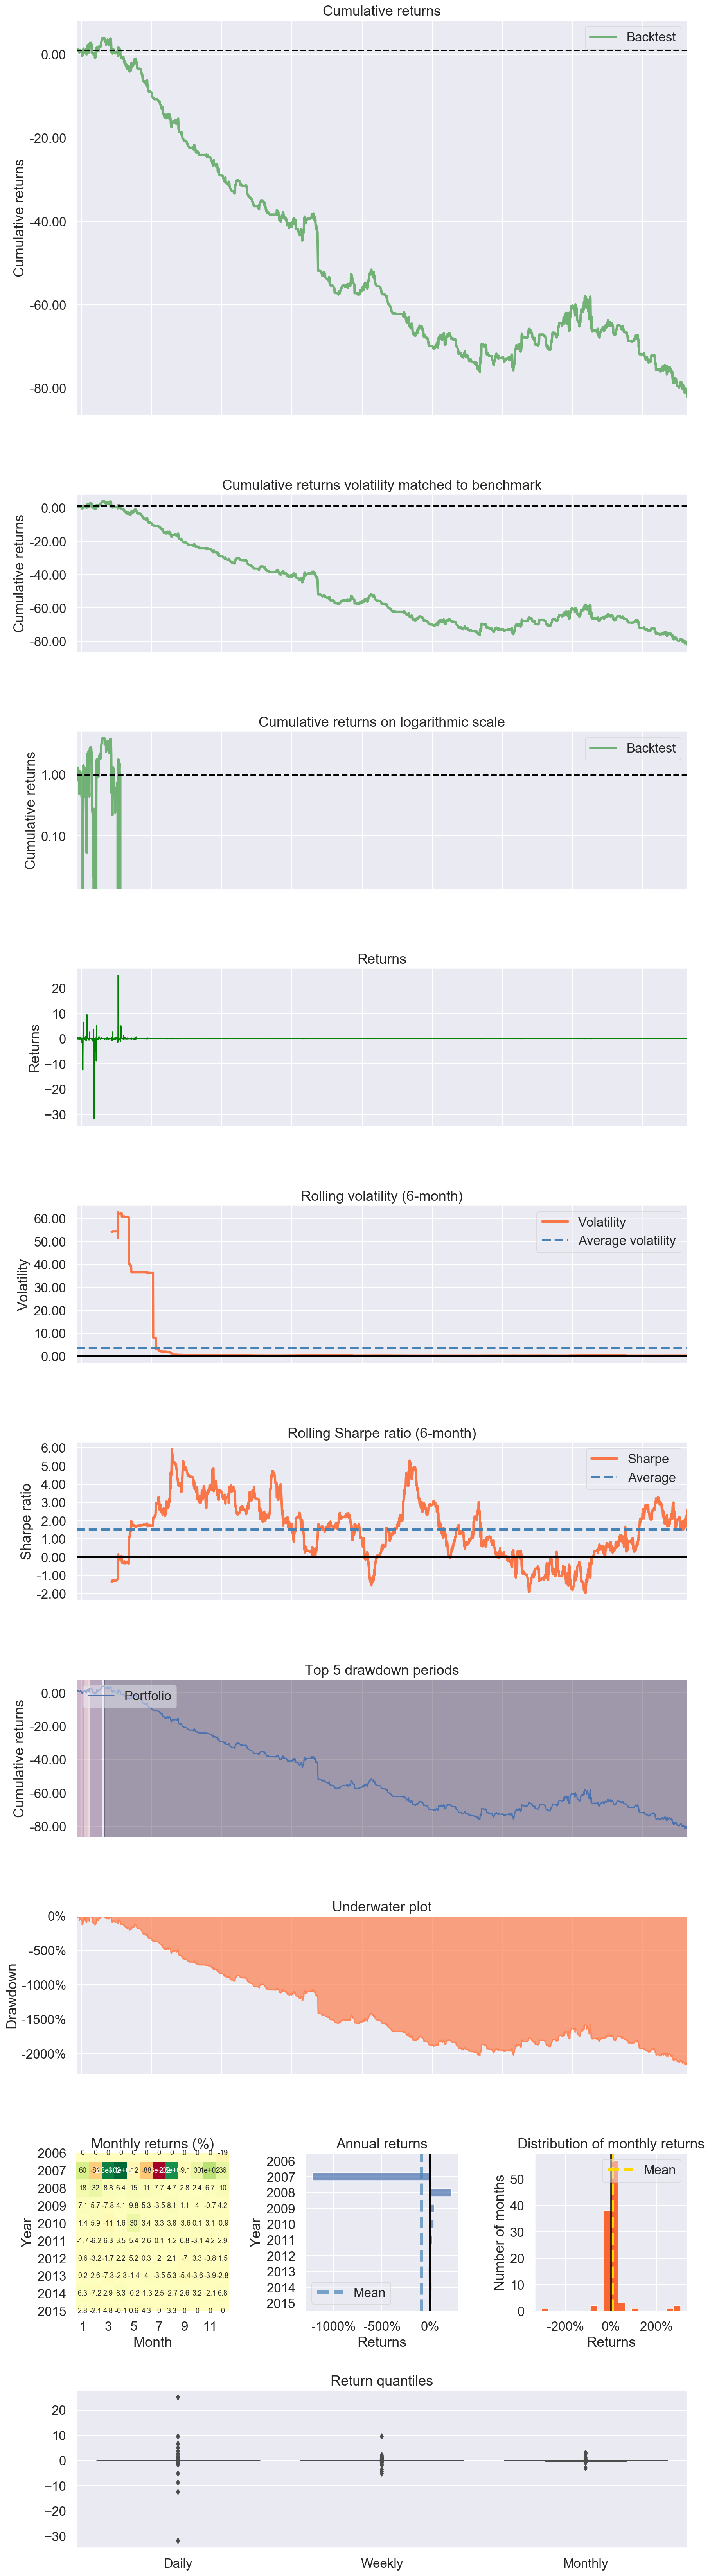

In [41]:
pf.create_returns_tear_sheet(returns = bt.balance['% change'].dropna())